A/B–тестирование. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

В качестве входных данных Вы имеете 4 файла:
- groups - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- groups_add - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- active_studs - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- checks - файл с информацией об оплатах пользователей в дни проведения эксперимента. 


In [144]:
import pandas as pd
import pingouin as pg
import requests
import json
import seaborn as sns

In [5]:
# Список ссылок
file_ids = [
    "1x4yb0h5vbUHrN-nWk8XKv2n9CX1n_GH8",
    "17Ulct1PGnDew7i_X3yxG0KaEyD4LHXAU",
    "12J1SuOrcNCg4yhRmU8Hxm4k-G018H_WZ",
    "1xjb4qmZTULegxeA0r13K32BQwJIxHR40"
]

In [11]:
dfs = []

for file_id in file_ids:
    url = f"https://drive.google.com/uc?id={file_id}"
    response = requests.get(url)
    data = json.loads(response.text)
    df = pd.DataFrame(data)
    dfs.append(df)

In [19]:
checks = dfs[0]
groups = dfs[1]
groups_add = dfs[2]
active_studs = dfs[3]

## EDA

### checks

In [21]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [28]:
print(f'кол-во строк - {checks.shape[0]}, кол-во столбцов {checks.shape[1]}')

кол-во строк - 541, кол-во столбцов 2


In [29]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [22]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [23]:
checks.duplicated().sum()

0

### groups

In [30]:
groups.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [31]:
print(f'кол-во строк - {groups.shape[0]}, кол-во столбцов {groups.shape[1]}')

кол-во строк - 92, кол-во столбцов 2


In [32]:
groups.dtypes

id      int64
grp    object
dtype: object

In [33]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [34]:
groups.duplicated().sum()

0

### groups_add

In [35]:
groups_add.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [36]:
print(f'кол-во строк - {groups_add.shape[0]}, кол-во столбцов {groups_add.shape[1]}')

кол-во строк - 74484, кол-во столбцов 2


In [37]:
groups_add.dtypes

id      int64
grp    object
dtype: object

In [38]:
groups_add.isna().sum()

id     0
grp    0
dtype: int64

In [39]:
groups_add.duplicated().sum()

0

### active_studs

In [40]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [41]:
print(f'кол-во строк - {active_studs.shape[0]}, кол-во столбцов {active_studs.shape[1]}')

кол-во строк - 8341, кол-во столбцов 1


In [42]:
active_studs.dtypes

student_id    int64
dtype: object

In [43]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [44]:
active_studs.duplicated().sum()

0

С данными все хорошо, нет дублиткатов, пропусков, формат данных соответствует нужному типу. 

Объеденим groups и groups_add(который нам прислали через 2 дня)

In [46]:
groups.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [47]:
all_groups = pd.concat([groups, groups_add])

In [48]:
all_groups.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [50]:
all_groups.shape

(74576, 2)

In [53]:
all_groups.duplicated().sum()

0

Посмотрим на кол-во пользователей в каждой группе

In [79]:
quan_group = all_groups.groupby('grp', as_index=False).size().rename(columns={'size':'quan'})

<Axes: xlabel='grp', ylabel='quan'>

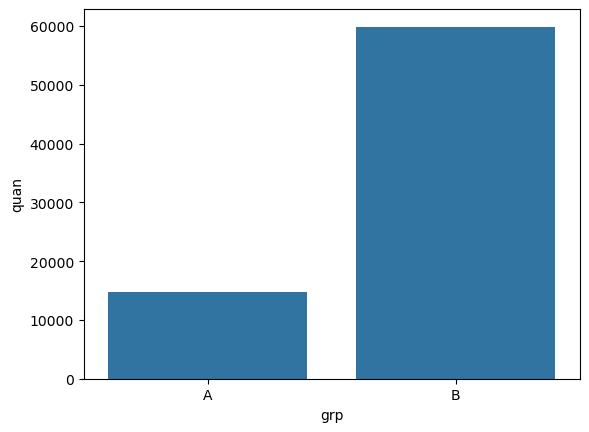

In [80]:
sns.barplot(quan_group, x='grp', y='quan')

группы распределены не равномерно

проверим распределние групп по пользователем которые были онлайн в эти дни. Для этого произведем inner join

In [110]:
online_user_all_group = active_studs.merge(all_groups, how='left', left_on='student_id', right_on='id')

In [111]:
online_user_all_group.shape

(8341, 3)

In [112]:
online_user_all_group.head()

,student_id,id,grp
0,581585,581585,A
1,5723133,5723133,A
2,3276743,3276743,B
3,4238589,4238589,A
4,4475369,4475369,B


In [113]:
online_user_all_group = online_user_all_group.drop(columns='id')

In [114]:
online_user_all_group.head()

,student_id,grp
0,581585,A
1,5723133,A
2,3276743,B
3,4238589,A
4,4475369,B


In [117]:
online_user_all_group.grp.value_counts()

grp
B    6803
A    1538
Name: count, dtype: int64

<Axes: xlabel='grp', ylabel='count'>

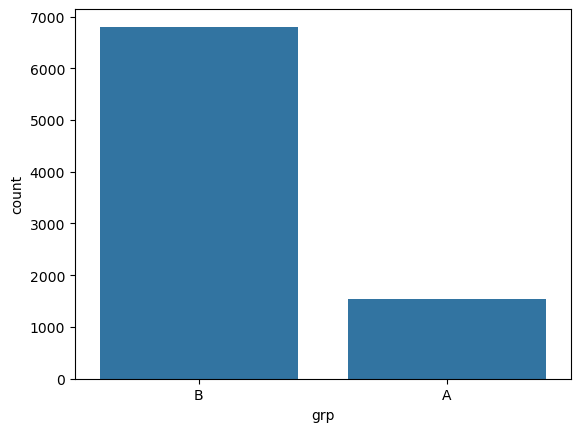

In [119]:
sns.barplot(online_user_all_group.grp.value_counts())

Соотношение количества пользователей, которые в день проведения эксперимента сделали покупку, в контрольной и тестовой группах осталось почти таким же.

## Выбор метрики для тестирования, тестирование

Наиболее важная метрика конверсия в оплату\
Далеепо считаем и сравним ARPPU и ARPU в 2 группах


для начла пометим всех пользователей которые совершили покупку

In [121]:
checks['paind'] = 1

In [122]:
checks.head()

,student_id,rev,paind
0,1627,990.0,1
1,3185,690.0,1
2,25973,690.0,1
3,26280,690.0,1
4,100300,990.0,1


In [125]:
online_user_all_group.head()

,student_id,grp
0,581585,A
1,5723133,A
2,3276743,B
3,4238589,A
4,4475369,B


In [133]:
paid_studs = online_user_all_group.merge(checks[['student_id', 'paind']], on='student_id', how='left')

In [134]:
paid_studs.head()

,student_id,grp,paind
0,581585,A,NaN
1,5723133,A,NaN
2,3276743,B,NaN
3,4238589,A,NaN
4,4475369,B,NaN


In [136]:
paid_studs = paid_studs.fillna(0)

In [138]:
paid_studs['paind'] = paid_studs['paind'].astype('int')

In [139]:
paid_studs.head()

,student_id,grp,paind
0,581585,A,0
1,5723133,A,0
2,3276743,B,0
3,4238589,A,0
4,4475369,B,0


посмотрим на на кол-во ползьзователей купивших и некупивших в 2 группах

In [140]:
paid_studs.groupby('grp', as_index=False)['paind'].value_counts()

,grp,paind,count
0,A,0,1460
1,A,1,78
2,B,0,6489
3,B,1,314


In [150]:
pg.chi2_independence(data=paid_studs, x='grp', y='paind')

(paind            0           1
 grp                           
 A      1465.718979   72.281021
 B      6483.281021  319.718979,
 paind       0      1
 grp                 
 A      1460.5   77.5
 B      6488.5  314.5,
                  test    lambda      chi2  dof      pval    cramer     power
 0             pearson  1.000000  0.484808  1.0  0.486252  0.007624  0.107123
 1        cressie-read  0.666667  0.482018  1.0  0.487510  0.007602  0.106787
 2      log-likelihood  0.000000  0.476541  1.0  0.489993  0.007559  0.106127
 3       freeman-tukey -0.500000  0.472522  1.0  0.491829  0.007527  0.105643
 4  mod-log-likelihood -1.000000  0.468578  1.0  0.493642  0.007495  0.105168
 5              neyman -2.000000  0.460909  1.0  0.497200  0.007434  0.104245)

По результатам x²-теста независимости (p = 0.486), различия между контрольной (A) и тестовой (B) группами не являются статистически значимыми.

Это говорит о том, что новая механика оплаты не оказала существенного влияния на поведение пользователей в рамках данного эксперимента.

### Проверим показатели среднее значение суммы покупки для двух групп, включающих в себя только платящих пользователей (ARPPU)

In [159]:
arppu_test = online_user_all_group.merge(checks, on='student_id').drop(columns='paind')

In [161]:
arppu_test.head()

,student_id,grp,rev
0,1184303,A,1530.0000
1,3354191,B,1900.0001
2,3278734,B,1900.0000
3,720651,A,1980.0000
4,1232221,B,1900.0000


In [163]:
arppu_test.grp.value_counts()

grp
B    314
A     78
Name: count, dtype: int64

<Axes: xlabel='rev', ylabel='Count'>

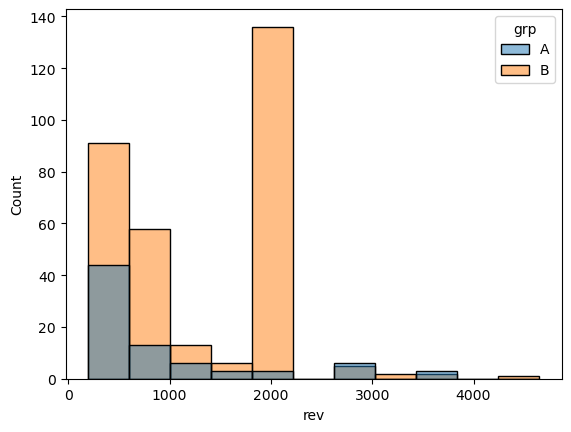

In [166]:
sns.histplot(x='rev', 
             data=arppu_test, 
             hue='grp')

In [172]:
pg.normality(data=arppu_test, dv='rev', group='grp', method='normaltest')

,W,pval,normal
grp,,,
A,30.378420,2.531687e-07,False
B,6.795663,3.344572e-02,False


тест на нормальность показал False, но все же выборки > 30 (центральная предельная теорема работает!)

Проверим гомоскедастичность 

In [174]:
pg.homoscedasticity(data=arppu_test, dv='rev', group='grp')

,W,pval,equal_var
levene,3.075682,0.080257,True


Дисперсии в группах A и B статистически не отличаются. Значит, условие гомоскедастичности выполняется.

Можем применять t-тест Стьюдента \
H0: среднеие в группах равны \
H1: среднее вгрупах различается

In [194]:
group_a = arppu_test[arppu_test['grp'] == 'A']['rev']
group_b = arppu_test[arppu_test['grp'] == 'B']['rev']

In [195]:
pg.ttest(x=group_a,y=group_b)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.86169,106.981668,two-sided,0.00507,"[-548.94, -99.64]",0.39646,6.536,0.878211


p < 0.05 — разница статистически значимая. Отвергаем 0 гипотезу. среднее вгрупах различается

<Axes: xlabel='grp', ylabel='rev'>

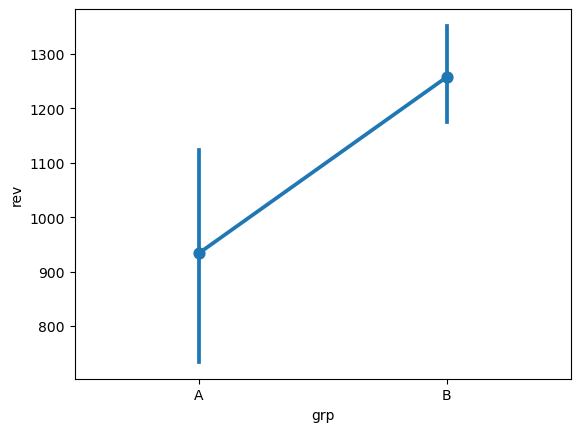

In [181]:
sns.pointplot(x='grp', y = 'rev', data = arppu_test)

Группа B показала заметно выше среднее значение ARPPU, чем группа A. Интервалы не пересекаются

### Проверим среднее значение суммы покупки для двух групп, учитывая всех пользователей, участвовавших в день проведения эксперимента (ARPU)

In [185]:
arpu_test = online_user_all_group.merge(checks, on='student_id', how='left').drop(columns='paind')
arpu_test = arpu_test.fillna(0)

In [186]:
arpu_test.head()

,student_id,grp,rev
0,581585,A,0.0
1,5723133,A,0.0
2,3276743,B,0.0
3,4238589,A,0.0
4,4475369,B,0.0


In [188]:
arpu_test.grp.value_counts()

grp
B    6803
A    1538
Name: count, dtype: int64

<Axes: xlabel='rev', ylabel='Count'>

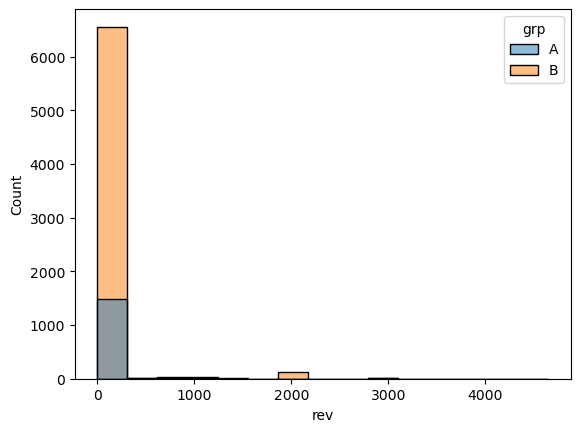

In [189]:
sns.histplot(x='rev', 
             data=arpu_test, 
             hue='grp')

выборки > 30 (центральная предельная теорема работает!)

In [191]:
pg.homoscedasticity(data=arpu_test, dv='rev', group='grp')

,W,pval,equal_var
levene,1.501461,0.220481,True


Дисперсии в группах A и B статистически не отличаются. Значит, условие гомоскедастичности выполняется.

Можем применять t-тест Стьюдента
H0: среднеие в группах равны
H1: среднее вгрупах различается

In [197]:
group_a_arpu = arpu_test[arpu_test['grp'] == 'A']['rev']
group_b_arpu = arpu_test[arpu_test['grp'] == 'B']['rev']

In [198]:
pg.ttest(x=group_a_arpu,y=group_b_arpu)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.286374,2416.748043,two-sided,0.198436,"[-27.04, 5.62]",0.034597,0.073,0.231965


p < 0.05 — разница статистически значимая. Отвергаем 0 гипотезу. среднее вгрупах различается

<Axes: xlabel='grp', ylabel='rev'>

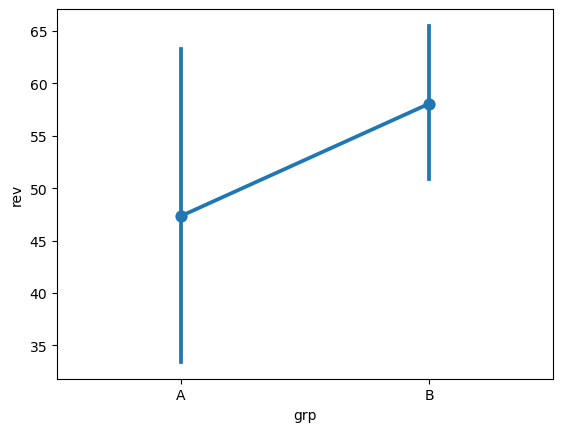

In [199]:
sns.pointplot(x='grp', y = 'rev', data = arpu_test)

## Выводы:
Для сравнения групп были взяты такие метрики как CR в оплату, ARPPU и ARPU. При тестировании конверсии с помощью критерия Хи-квадрат результат не дал стат.значимых различий, но при сравнении средних ARPPU и ARPU мы получили результат, который показывает, что эти показатели стат.значимо отличаются в контрольной и тестовой группах. В результате принимаем решения по выкатыванию новой механики оплаты.